In [2]:
import pandas as pd 
import json

In [3]:
with open("dataset_4-30.json") as f:
    data = json.load(f)

df = pd.json_normalize(data)
print(df.columns)

Index(['id', 'text', 'date', 'author_id', 'author_name', 'author_username',
       'retweet_count', 'hashtags', 'mentions', 'image_urls', 'tweet_url',
       'llm_image_classification', 'full_llm_image_response',
       'topical_categories', 'full_topical_categories_response',
       'reverse_image_search_results', 'dememe_reverse_image_search_results',
       'dememe_reverse_image_text', 'community_note.noteId',
       'community_note.noteAuthorParticipantId',
       'community_note.createdAtMillis', 'community_note.tweetId',
       'community_note.classification', 'community_note.believable',
       'community_note.harmful', 'community_note.validationDifficulty',
       'community_note.misleadingOther',
       'community_note.misleadingFactualError',
       'community_note.misleadingManipulatedMedia',
       'community_note.misleadingOutdatedInformation',
       'community_note.misleadingMissingImportantContext',
       'community_note.misleadingUnverifiedClaimAsFact',
       'commun

In [4]:
import langdetect
from langdetect import detect, DetectorFactory
from tqdm import tqdm 

tqdm.pandas()

In [5]:
def get_lang(text):
    try:
        return detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        return None

# Do a pie chart of the tweet's language 
df['text.lang'] = df['text'].progress_apply(lambda x: get_lang(x))

100%|██████████| 2293/2293 [00:09<00:00, 249.24it/s]


In [6]:
# Get the community note language
df['community_note.lang'] = df['community_note.summary'].progress_apply(lambda x: get_lang(x))

  0%|          | 0/2293 [00:00<?, ?it/s]

100%|██████████| 2293/2293 [00:06<00:00, 345.57it/s]


In [7]:
language_mapping = {
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "de": "German",
    "it": "Italian",
    "pt": "Portuguese",
    "zh-cn": "Chinese (Simplified)",
    "zh-tw": "Chinese (Traditional)",
    "ja": "Japanese",
    "ko": "Korean",
    "ru": "Russian",
    "ar": "Arabic",
    "hi": "Hindi",
    "bn": "Bengali",
    "pa": "Punjabi",
    "ur": "Urdu",
    "tr": "Turkish",
    "fa": "Persian",
    "pl": "Polish",
    "uk": "Ukrainian",
    "nl": "Dutch",
    "sv": "Swedish",
    "no": "Norwegian",
    "fi": "Finnish",
    "da": "Danish",
    "cs": "Czech",
    "ro": "Romanian",
    "hu": "Hungarian",
    "th": "Thai",
    "vi": "Vietnamese",
    "id": "Indonesian",
    "ms": "Malay",
}


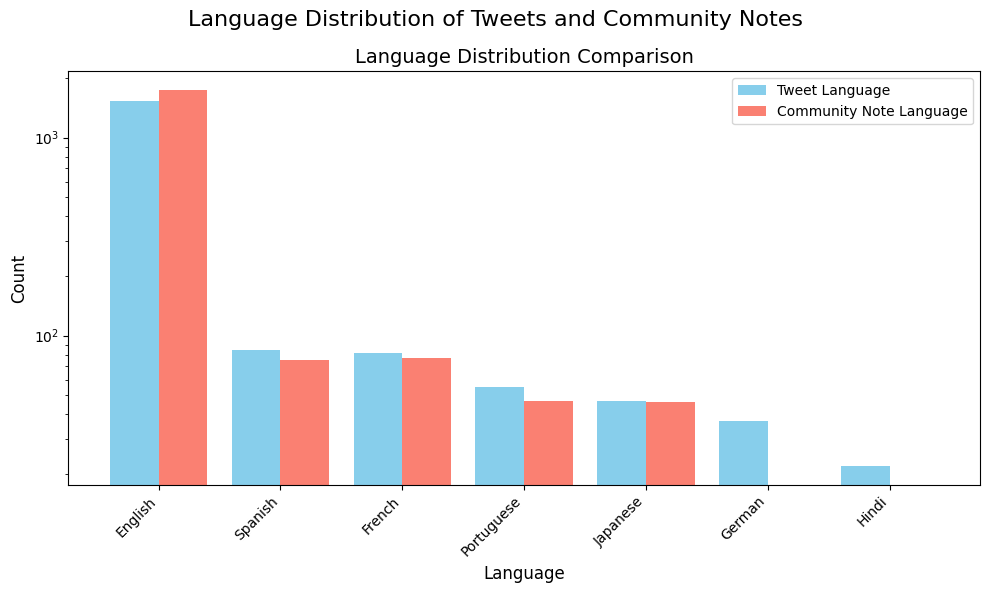

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Language Distribution of Tweets and Community Notes', fontsize=16)

# Using your preprocessed language data
lang_df = df[['text.lang', 'community_note.lang']].copy().dropna()

# Apply the language mapping to both columns
lang_df['text.lang'] = lang_df['text.lang'].map(language_mapping)
lang_df['community_note.lang'] = lang_df['community_note.lang'].map(language_mapping)

text_lang_counts = lang_df['text.lang'].value_counts()
text_lang_counts = text_lang_counts[text_lang_counts > (0.01 * len(lang_df))]

community_note_lang_counts = lang_df['community_note.lang'].value_counts()
community_note_lang_counts = community_note_lang_counts[community_note_lang_counts > (0.01 * len(lang_df))]

# Sort the value counts for consistent ordering
text_lang_counts = text_lang_counts.sort_index()
community_note_lang_counts = community_note_lang_counts.sort_index()


# Align the indexes of both counts (to ensure same languages)
all_languages = list(set(text_lang_counts.index).union(set(community_note_lang_counts.index)))
# Sort all languages by the count from text_lang_counts
all_languages.sort(key=lambda x: text_lang_counts.get(x, 0), reverse=True)

text_counts_aligned = text_lang_counts.reindex(all_languages, fill_value=0)
note_counts_aligned = community_note_lang_counts.reindex(all_languages, fill_value=0)

# Defining positions for side-by-side bars
x = np.arange(len(all_languages))
width = 0.4  # Width of each bar

# Plotting side-by-side bars
ax.bar(x - width / 2, text_counts_aligned, width=width, color='skyblue', label='Tweet Language')
ax.bar(x + width / 2, note_counts_aligned, width=width, color='salmon', label='Community Note Language')

# Customizing the plot
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Language Distribution Comparison', fontsize=14)
ax.set_xticks(x)
# Set y axis to log
ax.set_yscale('log')
ax.set_xticklabels(all_languages, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [17]:
topic_counts = {}
for item in df['topical_categories']:
    for topic in item:
        if topic in topic_counts:
            topic_counts[topic] += 1
        else:
            topic_counts[topic] = 1

# Sort the topics by count
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_topics)

[('Misattributed or Fabricated Visuals', 1490), ('Political Misinformation', 782), ('War, Conflict, and Geopolitics', 631), ('Social and Cultural Misinformation', 520), ('Conspiracy Theories', 470), ('Historical Revisionism', 265), ('Science and Technology Misinformation', 258), ('Media and Communication Misinformation', 235), ('Health and Medical Misinformation', 163), ('Criminal Activities and Scams', 125), ('Climate and Environmental Misinformation', 116), ('Crisis and Emergency Situations', 111), ('Corporate and Brand Misinformation', 75), ('Economic Misinformation', 74), ('Space Exploration', 43), ('Religious Conflicts', 42), ('Refugees and Migration', 34), ('Election Fraud/Integrity', 23), ('Protests and Social Movements', 15), ('Gender and Identity', 13), ('Child Safety/Abductions', 11), ('Fake News Sites/Articles', 10), ('Manipulated Media', 10), ('Vaccines and Immunization', 8), ('Out-of-Context Quotes', 8), ('Human Trafficking Misinformation', 6), ('Pandemics/Epidemics', 5), 

In [19]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [28]:
te = TransactionEncoder()
te_ary = te.fit(df['topical_categories']).transform(df['topical_categories'])
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_apriori, min_support=0.01, use_colnames=True)
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by confidence
rules = rules.sort_values(by='confidence', ascending=False)
rules



     support                                           itemsets
0   0.050589         (Climate and Environmental Misinformation)
1   0.204972                              (Conspiracy Theories)
2   0.032708               (Corporate and Brand Misinformation)
3   0.054514                    (Criminal Activities and Scams)
4   0.048408                  (Crisis and Emergency Situations)
..       ...                                                ...
69  0.043611  (Misattributed or Fabricated Visuals, Social a...
70  0.060619  (War, Conflict, and Geopolitics, Misattributed...
71  0.044483  (War, Conflict, and Geopolitics, Misattributed...
72  0.018317  (War, Conflict, and Geopolitics, Social and Cu...
73  0.011339  (War, Conflict, and Geopolitics, Misattributed...

[74 rows x 2 columns]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Election Fraud/Integrity),(Political Misinformation),0.010031,0.341038,0.010031,1.000000,2.932225,1.0,0.006610,inf,0.665639,0.029412,1.000000,0.514706
16,"(Conspiracy Theories, Space Exploration)",(Science and Technology Misinformation),0.012647,0.112516,0.011775,0.931034,8.274659,1.0,0.010352,12.868513,0.890410,0.103846,0.922291,0.517843
13,(Space Exploration),(Science and Technology Misinformation),0.018753,0.112516,0.017008,0.906977,8.060844,1.0,0.014898,9.540449,0.892684,0.148855,0.895183,0.529070
11,"(War, Conflict, and Geopolitics)",(Misattributed or Fabricated Visuals),0.275185,0.649804,0.230266,0.836767,1.287723,1.0,0.051450,2.145377,0.308265,0.331450,0.533881,0.595565
23,"(War, Conflict, and Geopolitics, Political Mis...",(Misattributed or Fabricated Visuals),0.081989,0.649804,0.060619,0.739362,1.137823,1.0,0.007343,1.343610,0.131947,0.090318,0.255736,0.416325
7,(Religious Conflicts),(Misattributed or Fabricated Visuals),0.018317,0.649804,0.013519,0.738095,1.135874,1.0,0.001617,1.337113,0.121853,0.020653,0.252120,0.379450
12,(Religious Conflicts),(Social and Cultural Misinformation),0.018317,0.226777,0.013083,0.714286,3.149725,1.0,0.008930,2.706280,0.695247,0.056391,0.630489,0.385989
17,"(Science and Technology Misinformation, Space ...",(Conspiracy Theories),0.017008,0.204972,0.011775,0.692308,3.377578,1.0,0.008289,2.583842,0.716110,0.056017,0.612979,0.374877
24,"(War, Conflict, and Geopolitics, Social and Cu...",(Misattributed or Fabricated Visuals),0.064980,0.649804,0.044483,0.684564,1.053493,1.0,0.002259,1.110197,0.054306,0.066363,0.099259,0.376510
0,(Space Exploration),(Conspiracy Theories),0.018753,0.204972,0.012647,0.674419,3.290302,1.0,0.008803,2.441873,0.709379,0.059917,0.590478,0.368060
